Clone into git repo, by the exclamation mark (`!`) you are able to execute commands associated with your operating system. Try `!ls` for example, if you are on **MacOS** or **Linux** or `!dir` if you use **Windows**

In [1]:
!git clone https://github.com/thsis/INFOSYS;

Cloning into 'INFOSYS'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 53 (delta 23), reused 46 (delta 16), pack-reused 0
Unpacking objects: 100% (53/53), done.


Install required modules

In [0]:
!pip install -r INFOSYS/requirements.txt;

In [0]:
import os
import numpy as np
import pandas as pd

from INFOSYS.models.lstm import LSTMNET
from sklearn.metrics import mean_squared_error
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
from hyperopt.pyll.base import scope

from matplotlib import pyplot as plt

Using TensorFlow backend.


Start by loading the data.

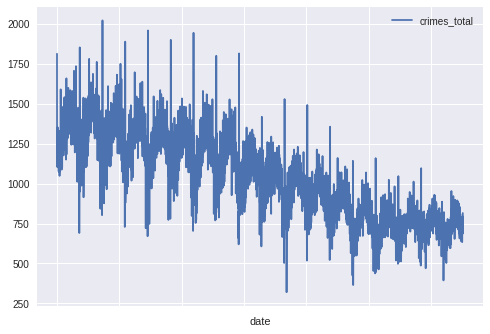

In [0]:
datapath = os.path.join("INFOSYS", "data", "crime_total.csv")
dataset = pd.read_csv(datapath, index_col="date",
                      dtype={"crimes_total": np.float32})
dataset.plot()

The first thing `hyperopt` wants from us, is to specify an objective function it can **minimize**. The cool thing is, it can minimize anything that returns a quantifiable `loss`. Since our task is to generate good predictions, it is reasonable to try to minimize some form of evaluation metric on our **test**-set. Because we have to perform a regression task the *mean squared error* is appropriate - other metrics are available though.

In [0]:
counter = 0


def objective(params):
    global counter
    
    model = LSTMNET(dataset, **params, verbose=False)
    model.train()
    predictions = model.predict(model.X_test)
    loss = mean_squared_error(y_true=model.y_test, y_pred=predictions)
    
    if counter % 100 == 0:
        print("Finished Trial Nr.: ", counter)
    
    counter += 1
    return {'loss': loss, 'status': STATUS_OK}

The next step for `hyperopt` is to specify the parameter-space it is supposed to perform a search upon. The cool thing about this library is that instead of performing a narrow minded gridsearch, that simply loops over the cartesian product of all provided combinations, it instead draws a new parameter from a distribution we specify.

Well, that's not the cool thing yet - additionally it estimates the gradient of our `objective` function with respect to to the parameters we provide and automatically updates the candidate accordingly. So over time it will gradually find the hyperparameters that minimize the objective.

The underlying math is called a *Tree of Parzen Estimators*, but to be honest I never bothered to look it up...

In [0]:
paramspace = {
        "maxlag": scope.int(hp.quniform("maxlag", 1, 365, 1)),
        "lstm_neurons": scope.int(hp.quniform("lstm_neurons", 1, 30, 1)),
        "batch_size": scope.int(hp.quniform("batch_size", 1, 10, 1))}

The most important thing for a practitioner is to know how to specify the right distribution for the hyperparameter candidates:

1. `hp.uniform` will draw from a (you guessed it) uniform distribution and will return parameters of `float`-type. This is not necessarily what we want. Nonetheless, the uniform distribution is the only one which puts no assumptions on our parameter space - the probability-mass gets shared evenly accross the whole space.

2. `hp.quniform` will also draw from a uniform distribution, and will also return a `float` - however, the parameter will always be divisible by 10 (`mod 10 == 0`). This is more suitable for our architecture, but it will still break the `keras`-code, which in turn expects a proper `int`. Therefore we wrap everything with the `scope.int` function.

3. `hp.normal` will assume a normal distribution. This is a rather strong assumption, where you as an analyst implicitly say that you have a pretty good idea of where your optimal hyperparameter lies. Values that are far from the expected value of the normal distribution become increasingly unlikely to be drawn.

4. `hp.lognormal` also makes an assumption on the optimal region for your hyperparameter but the tails of the distribution get more probability mass compared to the normal distribution.

In [0]:
trials = Trials()
best = fmin(fn=objective,
            space=paramspace,
            algo=tpe.suggest,
            trials=trials,
            max_evals=300)

# Fix type of optimal parameters
best = {key: int(val) for key, val in best.items()}
print(best)

Finished Trial Nr.:  0


The above code-cell is where the magic happens. We want 100 trials, but we also want to retrace the algorithm's thought process. To this effect we will plot the loss function that corresponds to each candidate hyperparameter per evaluation. The resulting scatterplot will easily tell us on which hyperparameters the algorithm *'homed in'*. These hyperparameters might then in turn be good candidates for a more classical, rigorous, grid-search. 

In [0]:
def plot_trials(trials, paramspace):
    """Plot path of hyperopt-search for analysis."""
    parameters = list(paramspace.keys())
    cols = len(parameters)
    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20, 5))

    for i, val in enumerate(parameters):
        xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
        ys = [t['result']['loss'] for t in trials.trials]
        xs, ys = zip(*sorted(zip(xs, ys)))
        axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.25)
        axes[i].set_title(val)
        axes[i].set_ylim([0, 0.002])

    return fig, axes

Whoa, this took a while. Even on their fancy graphics-card...

In [0]:
fig, axes = plot_trials(trials=trials, paramspace=paramspace)
plt.savefig(os.path.join("~", "INFOSYS", "models", "hyperopt-search.png"))

The next step is to plot the optimal model's fit on the train and test set.

Epoch 1/100
5210/5210 [==============================] - 4s 750us/step - loss: 0.0052
Epoch 2/100
5210/5210 [==============================] - 2s 331us/step - loss: 0.0037
Epoch 3/100
5210/5210 [==============================] - 2s 326us/step - loss: 0.0035
Epoch 4/100
5210/5210 [==============================] - 2s 327us/step - loss: 0.0033
Epoch 5/100
5210/5210 [==============================] - 2s 322us/step - loss: 0.0033
Epoch 6/100
5210/5210 [==============================] - 2s 321us/step - loss: 0.0032
Epoch 7/100
5210/5210 [==============================] - 2s 331us/step - loss: 0.0031
Epoch 8/100
5210/5210 [==============================] - 2s 329us/step - loss: 0.0031
Epoch 9/100
5210/5210 [==============================] - 2s 323us/step - loss: 0.0030
Epoch 10/100
5210/5210 [==============================] - 2s 331us/step - loss: 0.0030
Epoch 11/100
5210/5210 [==============================] - 2s 324us/step - loss: 0.0030
Epoch 12/100
5210/5210 [============================

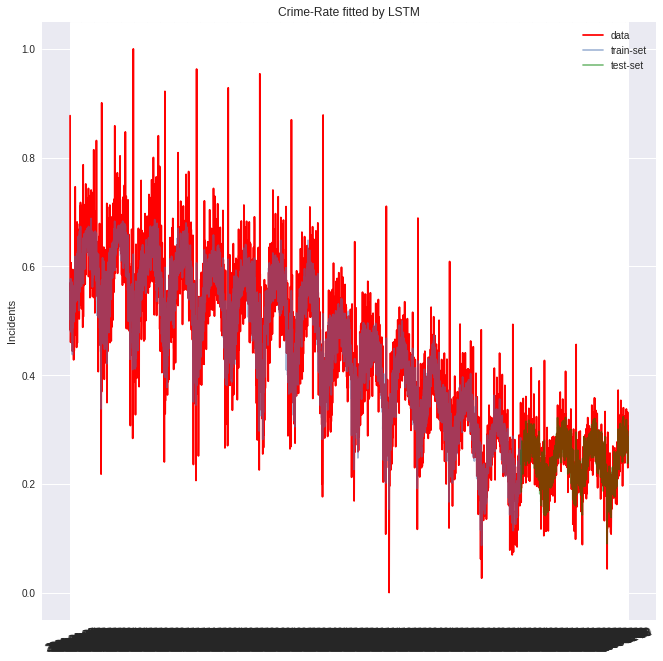

In [0]:
model = LSTMNET(data=dataset, **best)
model.train()
model.plot_fit()
plt.savefig(os.path.join("~", "INFOSYS", "models", "lstm-hyperopt-fit.png"))